# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
# The new version of dataset is only available in the tfds-nightly package.
%pip --no-cache-dir install tfds-nightly --user
# DON'T MISS TO RESTART THE KERNEL

     |████████████████████████████████| 3.5MB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 296kB 14.1MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [2]:
# TODO: Make all other necessary imports.
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import matplotlib.pyplot as plt
tfds.disable_progress_bar()
import logging
import time
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

# TODO: Create a training set, a validation set and a test set.
training_set, validation_set, test_set = dataset['train'],dataset['validation'], dataset['test']

I0817 11:25:13.420324 140578118842112 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
oxford_flowers102
2020-08-17 11:25:13.486371: W tensorflow/core/platform/cloud/google_auth_provider.cc:178] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Not found: Error executing an HTTP request: HTTP response code 404 with body '{"error":"invalid_request","error_description":"Service account not enabled on this instance"}'".
I0817 11:25:13.632934 140578118842112 dataset_info.py:421] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: oxford_flowers102/2.1.1
I0817 11:25:13.975966 140578118842112 dataset_info.py:352] Load dataset info from /tmp/tmprsn5q86itfds
I0817 11:25:13.988764 140578118842112 download_and_prepare.py:138] download_and_prepare for dataset oxford_flowers102/2.1.1.

In [4]:
# Check that dataset is a dictionary
print('dataset has type:', type(dataset))

# Print the keys of the dataset dictionary
print('\nThe keys of dataset are:', list(dataset.keys()))

dataset has type: <class 'dict'>

The keys of dataset are: ['test', 'train', 'validation']


## Explore the Dataset

In [5]:
# TODO: Get the number of examples in each set from the dataset info.
splits_names = ['train', 'test', 'validation']
for s in splits_names:
    print(f'The split {s} has {dataset_info.splits[s].num_examples} records')
    
total_num_examples = dataset_info.splits['train'].num_examples


# TODO: Get the number of classes in the dataset from the dataset info.

num_classes = dataset_info.features['label'].num_classes
print('There are {:,} classes in our dataset.\n'.format(num_classes))

dataset_info

The split train has 1020 records
The split test has 6149 records
The split validation has 1020 records
There are 102 classes in our dataset.



tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

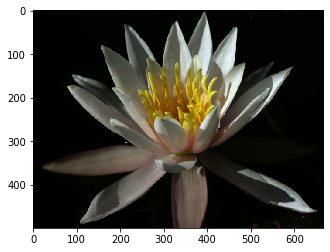

Image label: 72, image shape: (500, 667, 3)


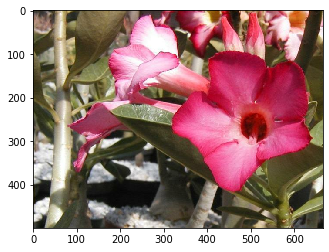

Image label: 84, image shape: (500, 666, 3)


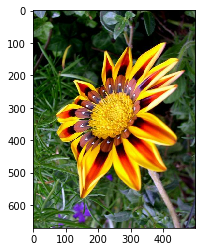

Image label: 70, image shape: (670, 500, 3)


In [6]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
n_im = 3
for im, lab in training_set.take(n_im):
    im = im.numpy()
    lab = lab.numpy()
    
    plt.imshow(im)
    plt.show()
    
    print(f'Image label: {lab}, image shape: {im.shape}')

Text(0.5, 1.0, '72')

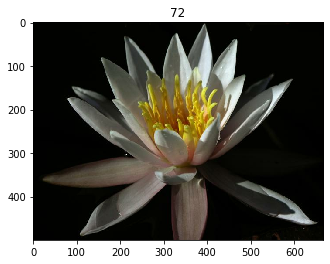

In [7]:
# TODO: Plot 1 image from the training set. 
for im, lab in training_set.take(1):
    im = im.numpy()
    lab = lab.numpy()
    
plt.imshow(im)
# Set the title of the plot to the corresponding image label. 
plt.title(lab)


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [8]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)
    
print(json.dumps(class_names, indent=10))

{
          "21": "fire lily",
          "3": "canterbury bells",
          "45": "bolero deep blue",
          "1": "pink primrose",
          "34": "mexican aster",
          "27": "prince of wales feathers",
          "7": "moon orchid",
          "16": "globe-flower",
          "25": "grape hyacinth",
          "26": "corn poppy",
          "79": "toad lily",
          "39": "siam tulip",
          "24": "red ginger",
          "67": "spring crocus",
          "35": "alpine sea holly",
          "32": "garden phlox",
          "10": "globe thistle",
          "6": "tiger lily",
          "93": "ball moss",
          "33": "love in the mist",
          "9": "monkshood",
          "102": "blackberry lily",
          "14": "spear thistle",
          "19": "balloon flower",
          "100": "blanket flower",
          "13": "king protea",
          "49": "oxeye daisy",
          "15": "yellow iris",
          "61": "cautleya spicata",
          "31": "carnation",
          "64": "silve

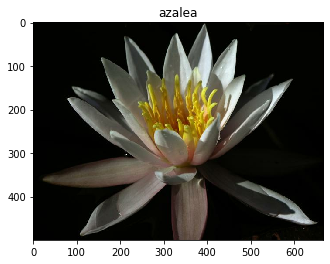

In [9]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for im, lab in training_set.take(1):
    im = im.numpy()
    lab = lab.numpy()

    plt.imshow(im)
    plt.title(class_names[str(lab)])

## Create Pipeline

In [12]:
# TODO: Create a pipeline for each set.

batch_size = 32
im_size = 224
train_split = 60

num_training_examples = (total_num_examples * train_split) // 100

def format_image(im, lab):
    im = tf.cast(im, tf.float32)
    im = tf.image.resize(im, (im_size, im_size))
    im /= 255
    return im, lab


training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [25]:
# TODO: Build and train your network.
# TODO: Build and train your network.
print('GPU mode enabled?', tf.test.is_gpu_available())

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Reusing downloaded model and setting it as not-trainable. 
feat_extractor = hub.KerasLayer(URL, input_shape=(im_size, im_size,3))
feat_extractor.trainable = False


model = tf.keras.Sequential([feat_extractor,
                             tf.keras.layers.Dense(250, activation = 'relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(num_classes, activation = 'softmax')])

model.summary()


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Callbacks
callback_path = "./best_weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(callback_path, save_best_only=True, save_weights_only=False)

#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)


EPOCHS = 250

history_callback = model.fit(training_batches,
                    epochs = EPOCHS,
                    callbacks = [checkpoint, early_stopping],
                    validation_data = validation_batches)


GPU mode enabled? True
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_17 (Dense)             (None, 250)               320250    
_________________________________________________________________
dropout_12 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 102)               25602     
Total params: 2,603,836
Trainable params: 345,852
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 13s 410ms/step - loss: 4.3953 - accuracy: 0.0922 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/250
32/32 [==============================] - 7s 211ms

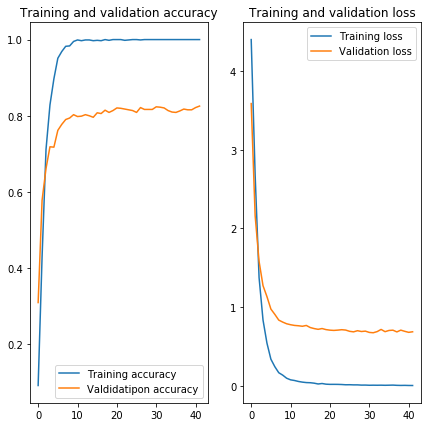

In [26]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

train_acc = history_callback.history['accuracy']
val_acc = history_callback.history['val_accuracy']

train_loss = history_callback.history['loss']
val_loss = history_callback.history['val_loss']

ep_range = range(len(history_callback.history['accuracy']))


# Plotting
plt.figure(figsize=(7,7))

# First plot
plt.subplot(1,2,1)
plt.title('Training and validation accuracy')
plt.plot(ep_range, train_acc, label = 'Training accuracy')
plt.plot(ep_range, val_acc, label = 'Valdidatipon accuracy')
plt.legend(loc = 'lower right')

# Second plot
plt.subplot(1,2,2)
plt.title('Training and validation loss')
plt.plot(ep_range, train_loss, label='Training loss')
plt.plot(ep_range, val_loss, label = 'Validation loss')
plt.legend(loc='upper right')



## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [27]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

loss, acc = model.evaluate(testing_batches)

193/193 [==============================] - 19s 98ms/step - loss: 0.8582 - accuracy: 0.7876


In [36]:
print('\nTesting set:\n - Loss = {:,.2f} \n - Accuracy = {:,.2%}' .format(loss,acc))


Testing set:
 - Loss = 0.86 
 - Accuracy = 78.76%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [29]:
# TODO: Save your trained model as a Keras model.

filepath_saved_model = './image_classifier.h5'

model.save(filepath_saved_model)

## Load the Keras Model

Load the Keras model you saved above.

In [30]:
# TODO: Load the Keras model

reloaded_model = tf.keras.models.load_model(filepath_saved_model, custom_objects={'KerasLayer':hub.KerasLayer})

reloaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_17 (Dense)             (None, 250)               320250    
_________________________________________________________________
dropout_12 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 102)               25602     
Total params: 2,603,836
Trainable params: 345,852
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [39]:
# TODO: Create the process_image function

def process_image(im):
    # Converting to tensor
    im = tf.convert_to_tensor(im, dtype = tf.float32)
    # Resizing the image
    im = tf.image.resize(im, (im_size, im_size))
    # Normalizing the output
    im /= 255
    return im.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

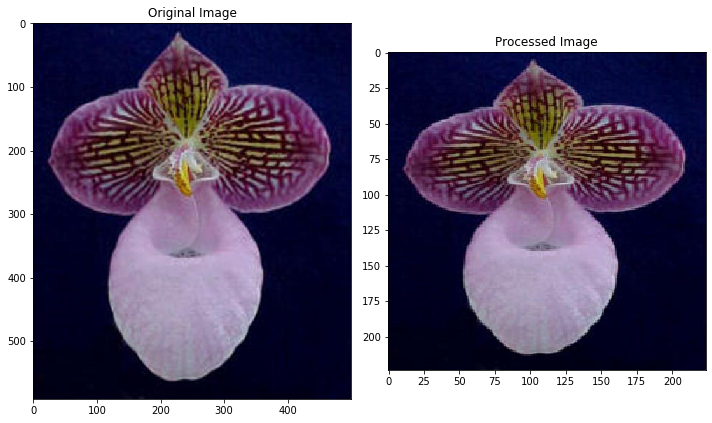

In [40]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [33]:
# TODO: Create the predict function
def predict(image_path, model, top_k):

    im = Image.open(image_path)
    
    im = np.asarray(im)
    
    im = process_image(im)
    
    expanded_im = np.expand_dims(im, axis=0)

    probs = model.predict(expanded_im)
    
    top_k_probs, top_k_indices = tf.nn.top_k (probs, k = top_k)

    top_k_probs = top_k_probs.numpy()
    top_k_indices = top_k_indices.numpy()
    
    
    return top_k_probs, top_k_indices, im

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 


Top 5 predictions for image: cautleya_spicata.jpg
Prediction 1: "cautleya spicata" (index: 60) ---> 99.8674%
Prediction 2: "red ginger" (index: 23) ---> 0.0463%
Prediction 3: "wallflower" (index: 45) ---> 0.0308%
Prediction 4: "snapdragon" (index: 10) ---> 0.0187%
Prediction 5: "siam tulip" (index: 38) ---> 0.0108%


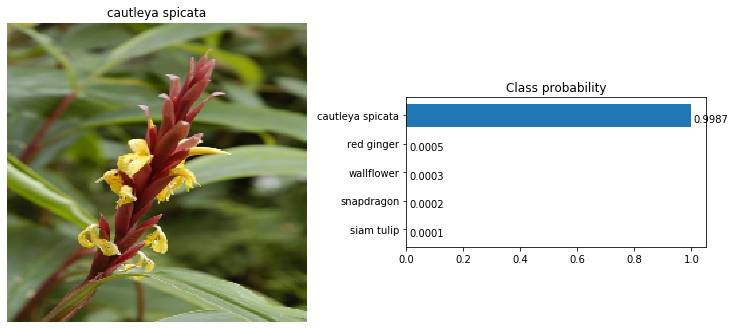


Top 5 predictions for image: hard-leaved_pocket_orchid.jpg
Prediction 1: "hard-leaved pocket orchid" (index: 1) ---> 99.9895%
Prediction 2: "anthurium" (index: 79) ---> 0.0015%
Prediction 3: "mallow" (index: 96) ---> 0.0011%
Prediction 4: "spring crocus" (index: 66) ---> 0.0010%
Prediction 5: "canterbury bells" (index: 2) ---> 0.0009%


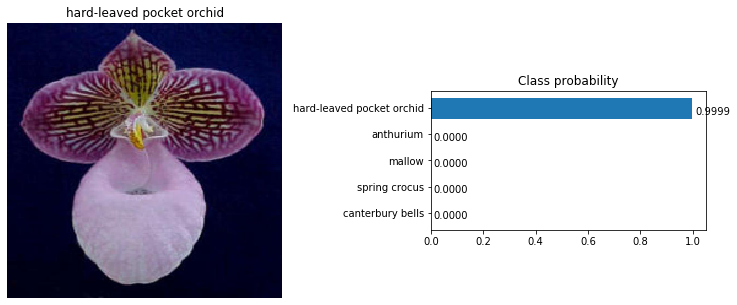


Top 5 predictions for image: orange_dahlia.jpg
Prediction 1: "orange dahlia" (index: 58) ---> 57.6583%
Prediction 2: "english marigold" (index: 4) ---> 29.5147%
Prediction 3: "blanket flower" (index: 99) ---> 6.2548%
Prediction 4: "osteospermum" (index: 65) ---> 2.3710%
Prediction 5: "black-eyed susan" (index: 62) ---> 1.3975%


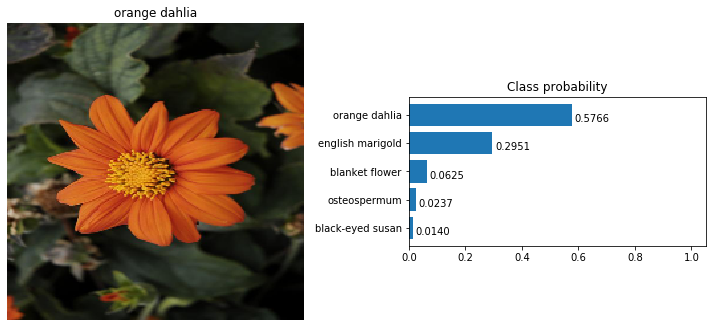


Top 5 predictions for image: wild_pansy.jpg
Prediction 1: "wild pansy" (index: 51) ---> 99.9949%
Prediction 2: "balloon flower" (index: 18) ---> 0.0028%
Prediction 3: "silverbush" (index: 63) ---> 0.0012%
Prediction 4: "mexican aster" (index: 33) ---> 0.0003%
Prediction 5: "buttercup" (index: 47) ---> 0.0002%


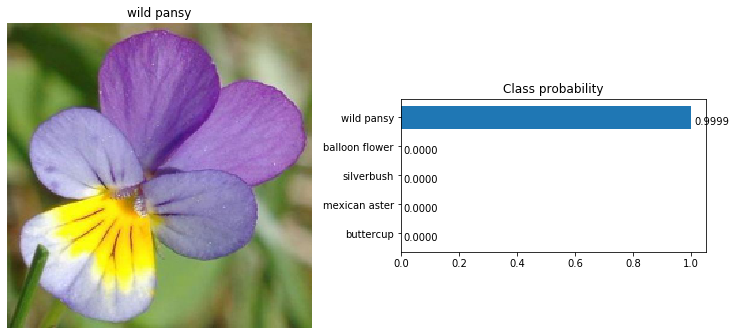

In [35]:
# TODO: Plot the input image along with the top 5 classes

im_vector = ['cautleya_spicata.jpg', 'hard-leaved_pocket_orchid.jpg', 'orange_dahlia.jpg', 'wild_pansy.jpg']
top_k = 5

for im in im_vector:
    #Build the image file path
    path = f'./test_images/{im}'
    
    #Predict for our image (image path) using our model. We get also the top_k probabilities. 
    top_k_prob, top_k_ind, image = predict(path, model, top_k)
    
    fl_classes = []   
    # Once we have the prediction (probabilities and indexes of classes). Let's get the classes (flowers names) using top_k_indices 
    for idx in top_k_ind[0]:
        fl_classes.append(class_names[str(idx+1)])        

    print(f'\nTop {top_k} predictions for image: {im}')
    for i in range(top_k):
        print('Prediction {}: \"{}\" (index: {}) ---> {:,.4%}'.format(i+1,fl_classes[i],top_k_ind[0][i],top_k_prob[0][i]))

    
    fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(fl_classes[0])
    
    y_pos = range(top_k)
    ax2.barh(y_pos,top_k_prob[0])
    ax2.set_aspect(0.1)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(fl_classes);
    ax2.invert_yaxis() 
    ax2.set_xlim(0, 1.05)
    plt.tight_layout()
    
    for i, v in enumerate(top_k_prob[0]):
        ax2.text(v + 0.01, i + .25, "{:.4f}".format(v))
    plt.show()

    
    
    
    